<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/Nancy_notebook/BasicModelCNN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [27]:
# Import Tensor Flow and necessary libvraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from PIL import ImageFile

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential

# others
import os, gc, time, pathlib
import tqdm, re, json
import imghdr

In [6]:

# environmental variables
TRAIN_DATA_PATH = '/content/drive/MyDrive/MMAI_Train/'
VALID_DATA_PATH = '/content/drive/MyDrive/MMAI_valid/'

CLASS_NAMES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASS_NAMES)

In [2]:
# checking availability of GPUs/TPUs
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Load Data Using a Keras Utility**

Standard way of pulling data is from websit:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Since I already download the file in the googledrive, Only Path is good enough 
#1 it iwll unizpped on "/content"
import pathlib
data = pathlib.Path('/content/folders_inside_zip') 
count = len(list(data.glob('*/*.jpg')))
count
#2 it if it already unziped in google drive
import pathlib
data = pathlib.Path('/content/gdrive/My Drive/TrainingPictures/') 
count = len(list(data.glob('*.jpg')))
count

In [8]:
# environmental variables
path_to_dir_train = "/content/drive/MyDrive/MMAI_Train/"
path_to_dir_valid = "/content/drive/MyDrive/MMAI_valid/"
     

Found 25835 files belonging to 11 classes.
Using 20668 files for training.


Found 25851 files belonging to 11 classes.
Using 5170 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


# **Visualize the Data**

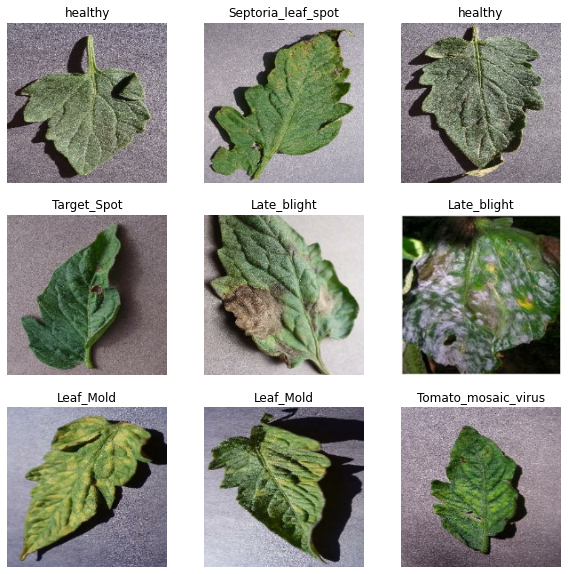

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [86]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). 

The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.:

# **Better Performance with the tf.data API**
GPUs and TPUs can radically reduce the time required to execute a single training step. Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished. The tf.data API helps to build flexible and efficient input pipelines. This document demonstrates how to use the tf.data API to build highly performant TensorFlow input pipelines.

Before you continue, check the Build TensorFlow input pipelines guide to learn how to use the tf.data API.

https://www.tensorflow.org/guide/data_performance

Configure the Dataset for performance 

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [16]:
normalization_layer = layers.Rescaling(1./255)


Check the image quality and remove the not formated image

In [19]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images
     

In [20]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images

In [21]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [48]:

# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(path_to_dir_train)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(path_to_dir_valid)
     

CPU times: user 0 ns, sys: 11 µs, total: 11 µs
Wall time: 19.8 µs
-------------------- check training set image quality. --------------------
-------------------- check test and validation set image quality. --------------------


In [51]:
# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(path_to_dir_train)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(path_to_dir_valid)
     

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|████████████████████████████████████████| 1004/1004 [00:00<00:00, 1748.15file/s]


-------------------- check test and validation set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████████| 252/252 [00:00<00:00, 1479.62file/s]


In [52]:

%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train3 = image_quality_check3(path_to_dir_train)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test3 = image_quality_check3(path_to_dir_valid)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.3 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████| 1004/1004 [00:00<00:00, 614756.38file/s]


-------------------- check test and validation set image quality. --------------------


powdery_mildew         : 100%|████████████████████████████████████████| 252/252 [00:00<00:00, 521442.83file/s]


In [53]:
move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))

Move 0 images with bad quality.


In [54]:

# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25836
6677


After Clean Data Then Build Model 

In [91]:
## Define some parameters for the loader
batch_size = 32
img_height = 224
img_width =224

In [92]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25835 files belonging to 11 classes.
Using 20668 files for training.


In [93]:
valid_test_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_dir_train,
  validation_split=0.2,
  subset='both',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




Found 25835 files belonging to 11 classes.
Using 20668 files for training.
Using 5167 files for validation.


In [94]:
valid_ds = valid_test_ds[0]
test_ds = valid_test_ds[1]

In [95]:
# audit - make sure validation and test sets are approximately follow same distribution
assert((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test does not match'


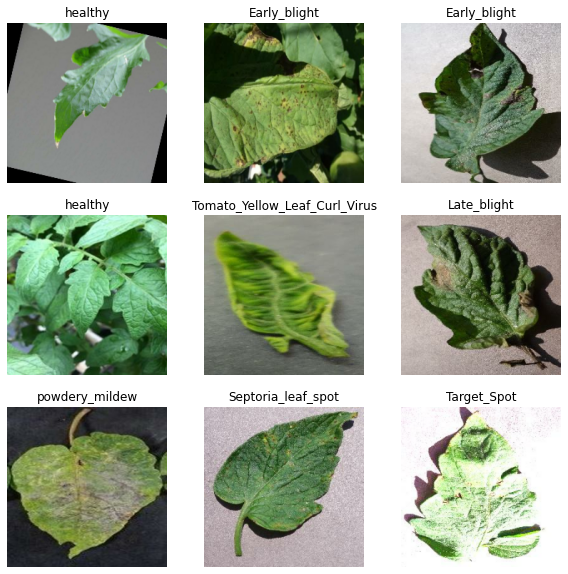

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [97]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [98]:
for image_batch, labels_batch in valid_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [99]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0038615935 0.82757026


A Basic Keras Model - Sequential Model
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach. 

In [100]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [101]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 64)       

In [103]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=5, 
    verbose=1
)

In [104]:

EPOCHS = 35

history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = EPOCHS,
    callbacks = [early_stopping]
)

Epoch 1/35
646/646 [==============================] - 38s 55ms/step - loss: 1.2918 - accuracy: 0.5550 - val_loss: 0.7251 - val_accuracy: 0.7542
Epoch 2/35
646/646 [==============================] - 35s 54ms/step - loss: 0.6799 - accuracy: 0.7686 - val_loss: 0.4784 - val_accuracy: 0.8393
Epoch 3/35
646/646 [==============================] - 35s 54ms/step - loss: 0.4651 - accuracy: 0.8417 - val_loss: 0.3776 - val_accuracy: 0.8752
Epoch 4/35
646/646 [==============================] - 35s 54ms/step - loss: 0.3149 - accuracy: 0.8946 - val_loss: 0.2179 - val_accuracy: 0.9264
Epoch 5/35
646/646 [==============================] - 35s 55ms/step - loss: 0.2127 - accuracy: 0.9282 - val_loss: 0.1816 - val_accuracy: 0.9385
Epoch 6/35
646/646 [==============================] - 35s 54ms/step - loss: 0.1510 - accuracy: 0.9497 - val_loss: 0.0963 - val_accuracy: 0.9693
Epoch 7/35
646/646 [==============================] - 35s 54ms/step - loss: 0.1086 - accuracy: 0.9655 - val_loss: 0.1203 - val_accuracy:

In [108]:
import numpy as np

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

xy = np.concatenate([x, y], axis=0)

In [112]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (8, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()
     

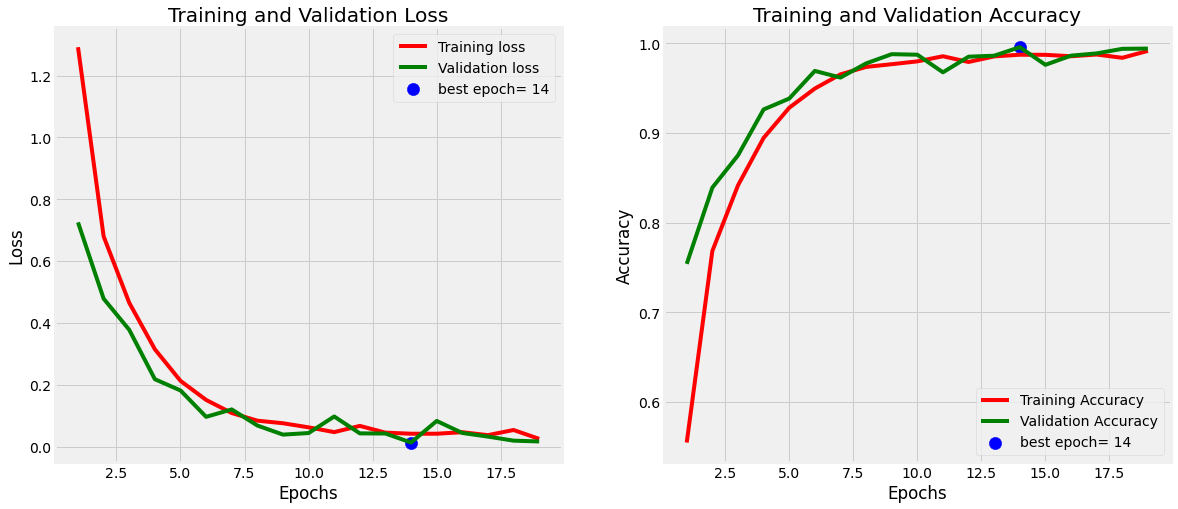

In [111]:

plot_training(history)